In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df=pd.read_csv(url, parse_dates=['Month'], index_col='Month')

In [ ]:
print(df.head())
print(df.describe())
print(df.shape)

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000
(144, 1)


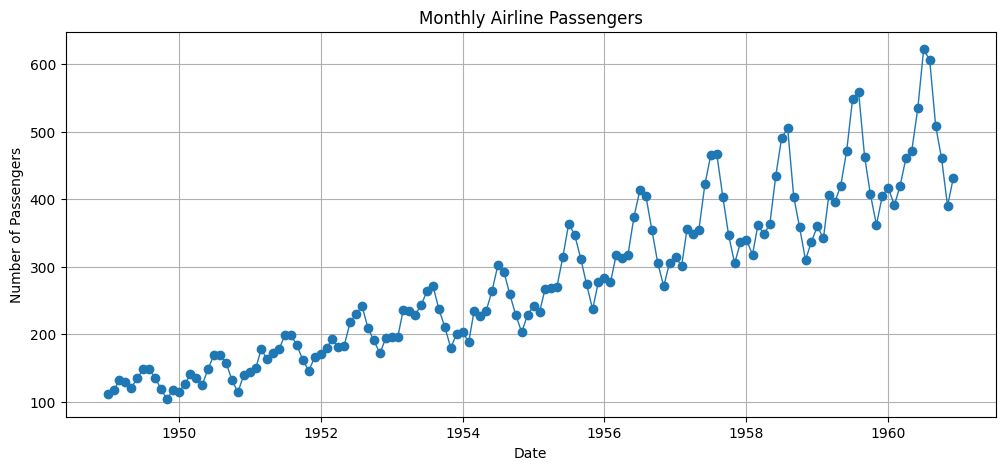

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Passengers'], marker='o', linewidth=1)
plt.title("Monthly Airline Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.grid(True)
plt.show()

In [ ]:
def run_adf_test(series, title="ADF Test"):
    print(f"\n{title}:")
    result=adfuller(series, autolag='AIC')
    adf_stat=result[0]
    p_value=result[1]
    used_lag=result[2]
    n_obs=result[3]
    crit_values=result[4]
    ic_best=result[5]
    print(f"ADF Statistic: {adf_stat}")
    print(f"p-value: {p_value}")
    print(f"Used lag: {used_lag}")
    print(f"Number of observations: {n_obs}")
    print("Critical Values:")
    for key, value in crit_values.items():
        print(f"   {key}: {value}")
    return {'adf_stat': adf_stat, 'p_value': p_value, 'crit_values': crit_values}

adf_res_original=run_adf_test(df['Passengers'], title="ADF Test on Original Series")


ADF Test on Original Series:
ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
Used lag: 13
Number of observations: 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


In [ ]:
if adf_res_original['p_value']>0.05:
    df_diff1=df['Passengers'].diff().dropna()
    print("\nPerformed first differencing (d=1).")
else:
    df_diff1=df['Passengers']
    print("\nSeries already stationary by ADF (no differencing applied).")


Performed first differencing (d=1).



ADF Test on 1st Differenced Series:
ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478
Used lag: 12
Number of observations: 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


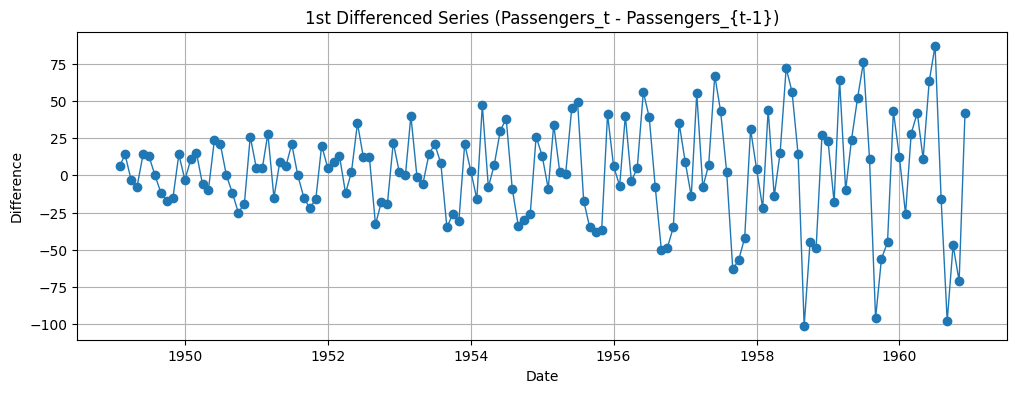

In [ ]:
adf_res_diff1=run_adf_test(df_diff1, title="ADF Test on 1st Differenced Series")

plt.figure(figsize=(12,4))
plt.plot(df_diff1.index, df_diff1.values, marker='o', linewidth=1)
plt.title("1st Differenced Series (Passengers_t - Passengers_{t-1})")
plt.xlabel("Date")
plt.ylabel("Difference")
plt.grid(True)
plt.show()


ADF Test on log-differenced Series:
ADF Statistic: -2.717130598388114
p-value: 0.07112054815086184
Used lag: 14
Number of observations: 128
Critical Values:
   1%: -3.4825006939887997
   5%: -2.884397984161377
   10%: -2.578960197753906


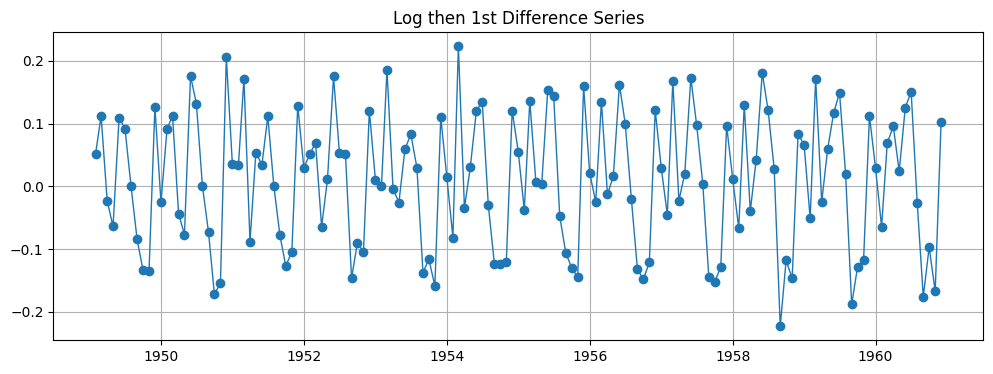


ADF Test on 2nd Differenced Series:
ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29
Used lag: 11
Number of observations: 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


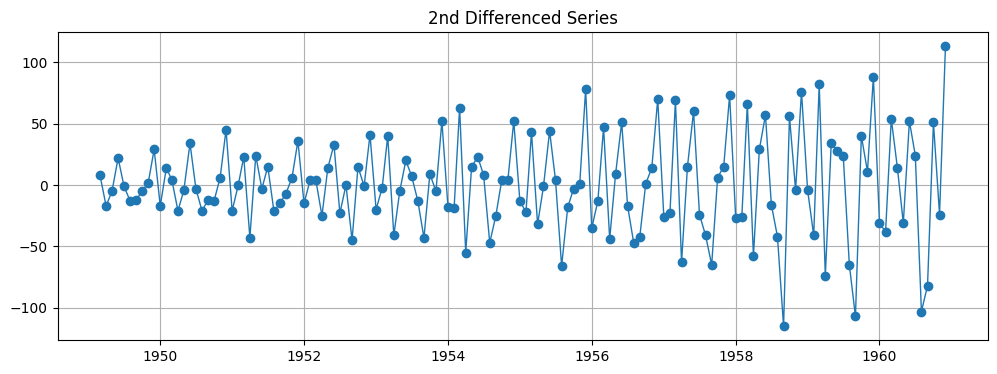


2nd differenced series is stationary. Using d=2 for ARIMA.

Selected d (number of differences) = 2


In [ ]:
d_value=0
if adf_res_original['p_value']<=0.05:
    d_value=0
    print("\nOriginal series considered stationary, using d=0 for ARIMA.")
else:
    if adf_res_diff1['p_value']<=0.05:
        d_value=1
        print("\n1st differenced series is stationary. Using d=1 for ARIMA.")
    else:
        df_log=np.log(df['Passengers'])
        df_log_diff1=df_log.diff().dropna()
        adf_res_logdiff=run_adf_test(df_log_diff1, title="ADF Test on log-differenced Series")
        plt.figure(figsize=(12,4))
        plt.plot(df_log_diff1.index, df_log_diff1.values, marker='o', linewidth=1)
        plt.title("Log then 1st Difference Series")
        plt.grid(True)
        plt.show()
        if adf_res_logdiff['p_value']<=0.05:
            d_value=1
            transformation='log'
            print("\nLog + 1st difference made the series stationary. Use d=1 with log transform.")
        else:
            df_diff2=df['Passengers'].diff().diff().dropna()
            adf_res_diff2=run_adf_test(df_diff2, title="ADF Test on 2nd Differenced Series")
            plt.figure(figsize=(12,4))
            plt.plot(df_diff2.index, df_diff2.values, marker='o', linewidth=1)
            plt.title("2nd Differenced Series")
            plt.grid(True)
            plt.show()
            if adf_res_diff2['p_value']<=0.05:
                d_value=2
                print("\n2nd differenced series is stationary. Using d=2 for ARIMA.")
            else:
                d_value=1
                print("\nCould not reach stationarity conclusively; defaulting to d=1.")
transformation = globals().get('transformation', None)
print(f"\nSelected d (number of differences) = {d_value}")
if transformation is not None:
    print("Selected transformation:", transformation)

In [ ]:
test_size=12
train=df['Passengers'][:-test_size]
test=df['Passengers'][-test_size:]
print("\nTrain length:", len(train))
print("Test length:", len(test))
if transformation=='log':
    train_for_model=np.log(train)
    test_for_model=np.log(test)
else:
    train_for_model=train
    test_for_model=test


Train length: 132
Test length: 12


In [ ]:
p=2
q=2
print(f"\nFitting ARIMA({p},{d_value},{q}) on training data...")
model = ARIMA(train_for_model, order=(p, d_value, q))
model_fit=model.fit()
print("\nARIMA model summary:")
print(model_fit.summary())


Fitting ARIMA(2,2,2) on training data...

ARIMA model summary:
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -622.495
Date:                Tue, 16 Sep 2025   AIC                           1254.990
Time:                        11:03:01   BIC                           1269.327
Sample:                    01-01-1949   HQIC                          1260.815
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5057      0.113     -4.477      0.000      -0.727      -0.284
ar.L2          0.1090      0.109      1.002      0.316      -0.104 

In [ ]:
n_steps=len(test)
forecast_result=model_fit.get_forecast(steps=n_steps)
predicted=forecast_result.predicted_mean
conf_int=forecast_result.conf_int()
if transformation=='log':
    predicted_final=np.exp(predicted)
    lower_conf=np.exp(conf_int['lower y'])
    upper_conf=np.exp(conf_int['upper y'])
else:
    predicted_final=predicted
    try:
        lower_conf=conf_int.iloc[:, 0]
        upper_conf=conf_int.iloc[:, 1]
    except:
        lower_conf=conf_int['lower y']
        upper_conf=conf_int['upper y']

In [ ]:
mse=mean_squared_error(test.values, predicted_final.values)
mae=mean_absolute_error(test.values, predicted_final.values)
rmse=np.sqrt(mse)
print("\nForecast Evaluation Metrics:")
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)


Forecast Evaluation Metrics:
MSE: 6346.148768370937
MAE: 59.462826130193186
RMSE: 79.6627188110658


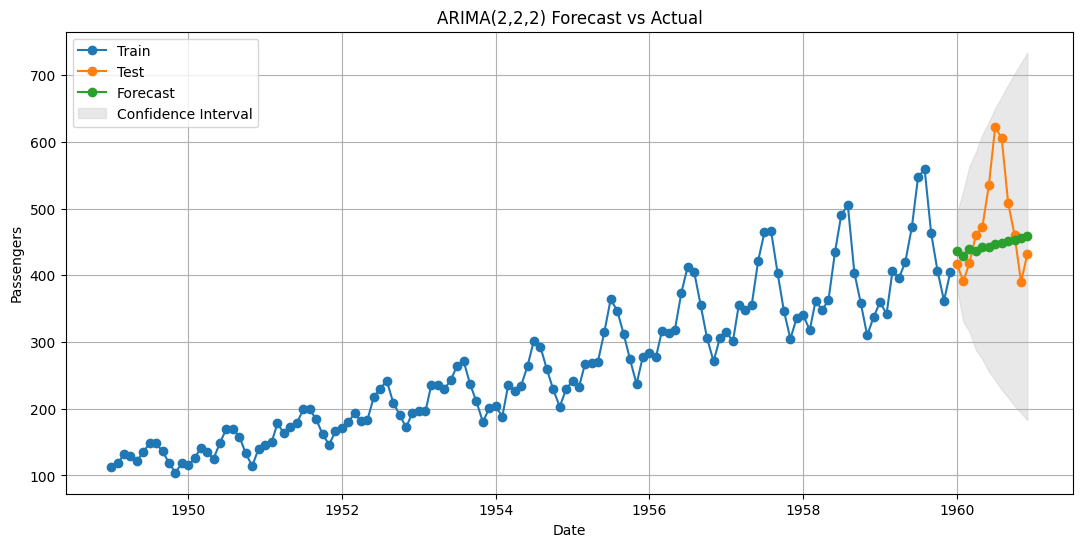

In [ ]:
plt.figure(figsize=(13,6))
plt.plot(train.index, train.values, label='Train', marker='o')
plt.plot(test.index, test.values, label='Test', marker='o')
plt.plot(test.index, predicted_final.values, label='Forecast', marker='o')
plt.fill_between(test.index, lower_conf, upper_conf, color='lightgray', alpha=0.5, label='Confidence Interval')
plt.title(f"ARIMA({p},{d_value},{q}) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()